# Packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

from pob_python import SP500_stocks_2015to2020, cryptos_2017to2021_daily

from scipy.stats import norm, skew, kurtosis
import arch

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prices and Returns

In [2]:
sp500 = yf.download('^GSPC', start='2007-01-01', end='2022-11-04')
sp500_prices = sp500['Close']

btc = yf.download('BTC-USD', start='2007-01-01', end='2022-11-04')
btc_prices = btc['Close']

C:\Users\anshu\AppData\Local\Temp\ipykernel_30592\3486998820.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2007-01-01', end='2022-11-04')
[*********************100%***********************]  1 of 1 completed
C:\Users\anshu\AppData\Local\Temp\ipykernel_30592\3486998820.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', start='2007-01-01', end='2022-11-04')
[*********************100%***********************]  1 of 1 completed


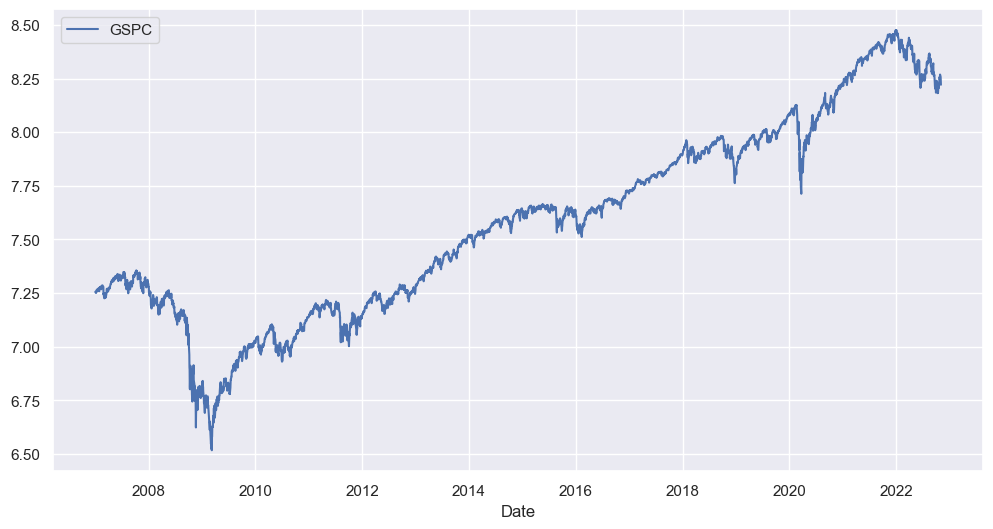

In [18]:
plt.figure(figsize=(12,6))
plt.plot(np.log(sp500_prices))
plt.xlabel('Date')
plt.legend(['GSPC'])
plt.show()

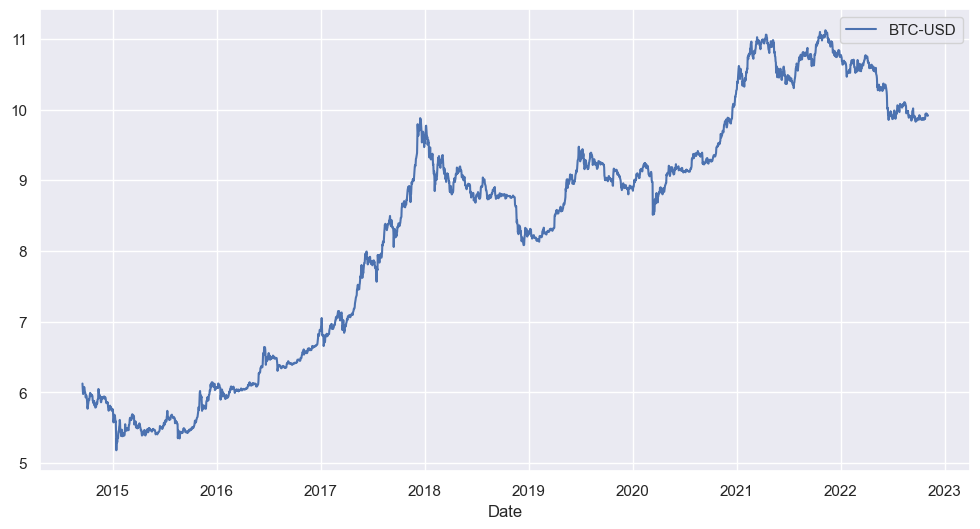

In [19]:
plt.figure(figsize=(12,6))
plt.plot(np.log(btc_prices))
plt.xlabel('Date')
plt.legend(['BTC-USD'])
plt.show()

In [56]:
sp500_returns = np.log(sp500_prices).diff().dropna()
btc_returns = np.log(btc_prices).diff().dropna()

In [23]:
def plot_returns(returns, title):
    plt.figure(figsize=(12, 6))
    plt.plot(returns, linewidth=0.5)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.show()    

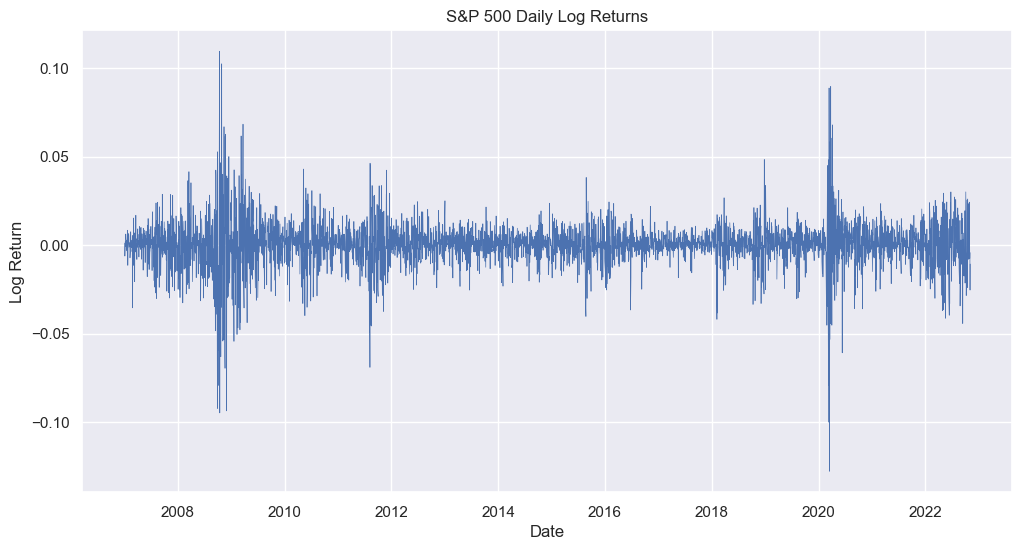

In [24]:
plot_returns(sp500_returns, 'S&P 500 Daily Log Returns')

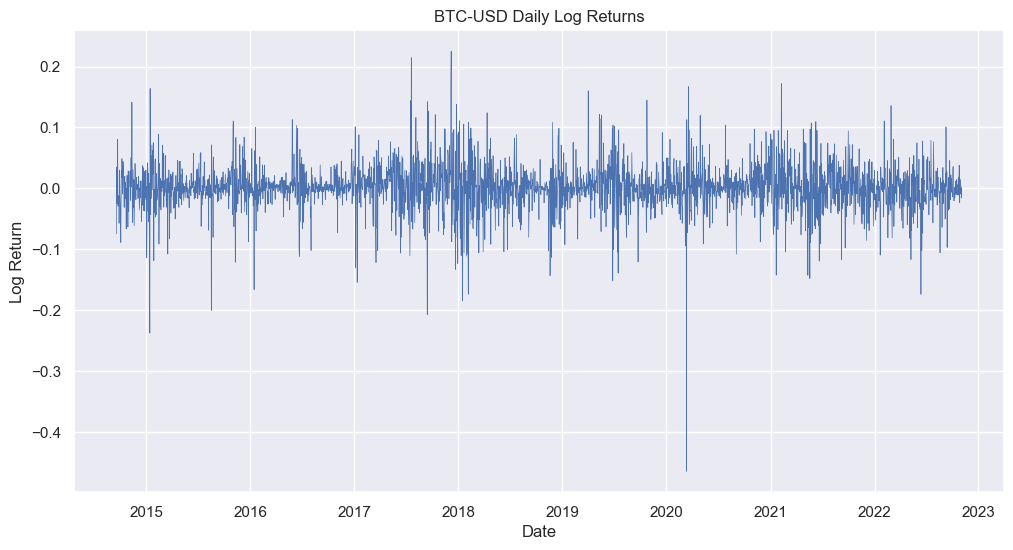

In [25]:
plot_returns(btc_returns, 'BTC-USD Daily Log Returns')

# Non-Gaussianity

In [35]:
def analyze_distribution(returns, asset_name):
    print(f"{asset_name} Distribution Properties")
    print(f"Skewness: {skew(returns).item():.4f}")
    print(f"Excess Kurtosis: {kurtosis(returns, fisher=False).item():.4f}")
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(returns, kde=False, ax=ax[0], stat='density')
    x = np.linspace(returns.min(), returns.max(), 100)
    ax[0].plot(x, norm.pdf(x, returns.mean(), 0.6*returns.std()))
    ax[0].set_title('Return Distribution')
    
    sm.graphics.qqplot(returns.squeeze(), line='45', fit=True, ax=ax[1])
    ax[1].set_xlim(-4, 4)
    ax[1].set_title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

S&P 500 Distribution Properties
Skewness: -0.5376
Excess Kurtosis: 14.9277


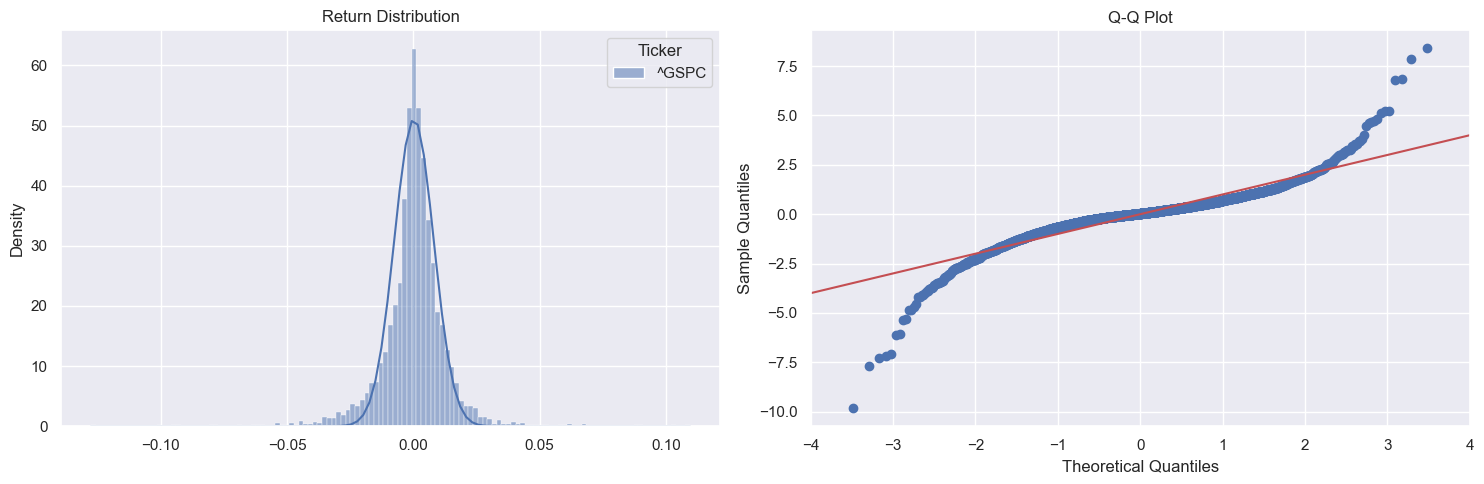

In [36]:
analyze_distribution(sp500_returns, 'S&P 500')

Bitcoin Distribution Properties
Skewness: -0.7678
Excess Kurtosis: 13.8594


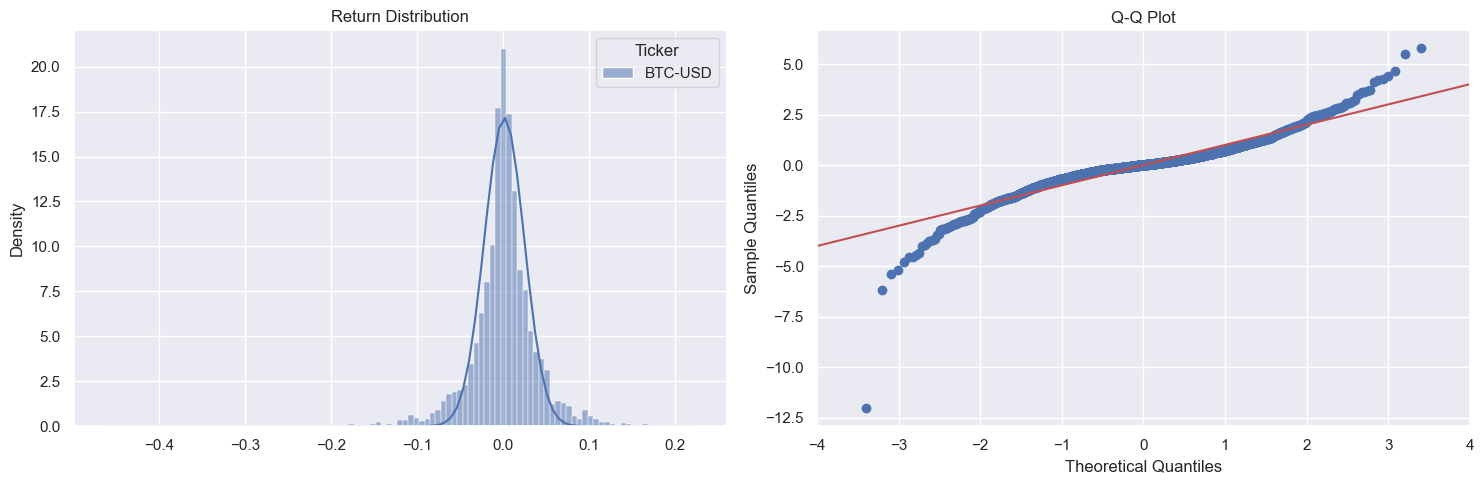

In [37]:
analyze_distribution(btc_returns, 'Bitcoin')

# Temporal Structure

## Linear Structure (autocorrelation)

In [38]:
def plot_autocorrelation(returns, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(returns, ax=ax1, lags=40)
    plot_pacf(returns, ax=ax2, lags=40)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

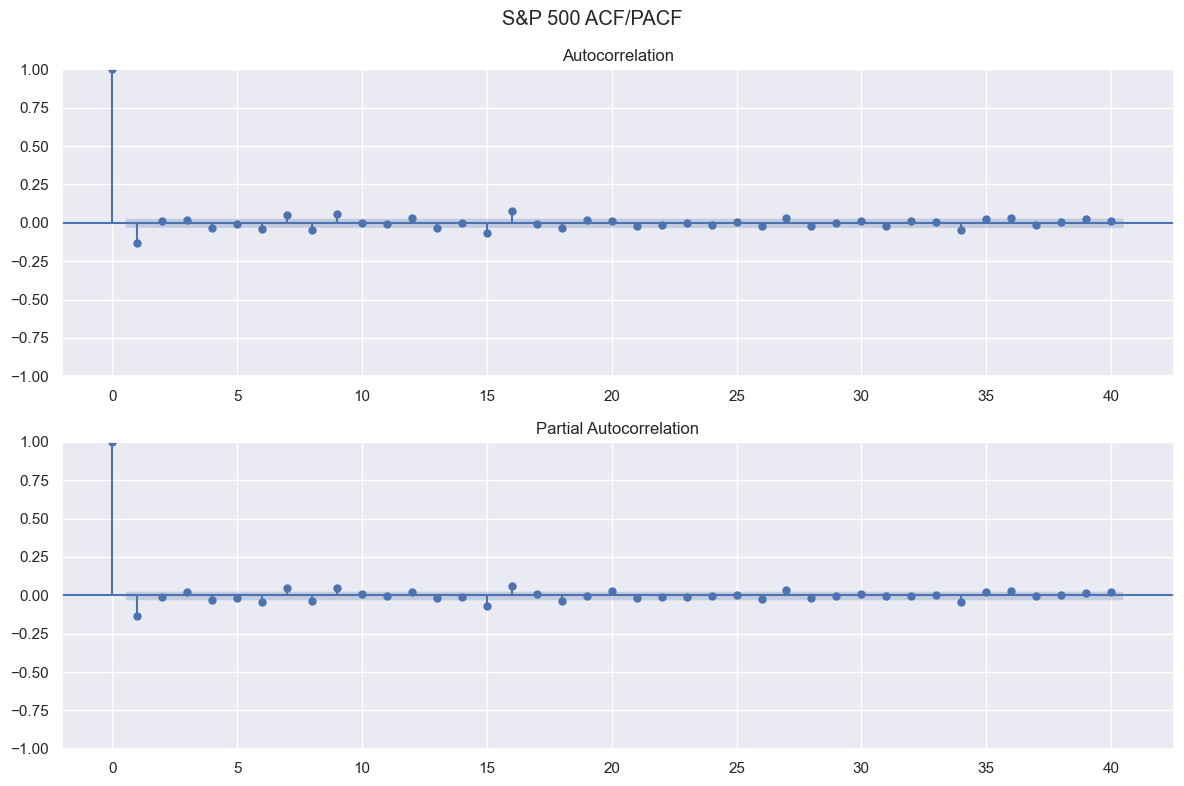

In [39]:
plot_autocorrelation(sp500_returns, 'S&P 500 ACF/PACF')

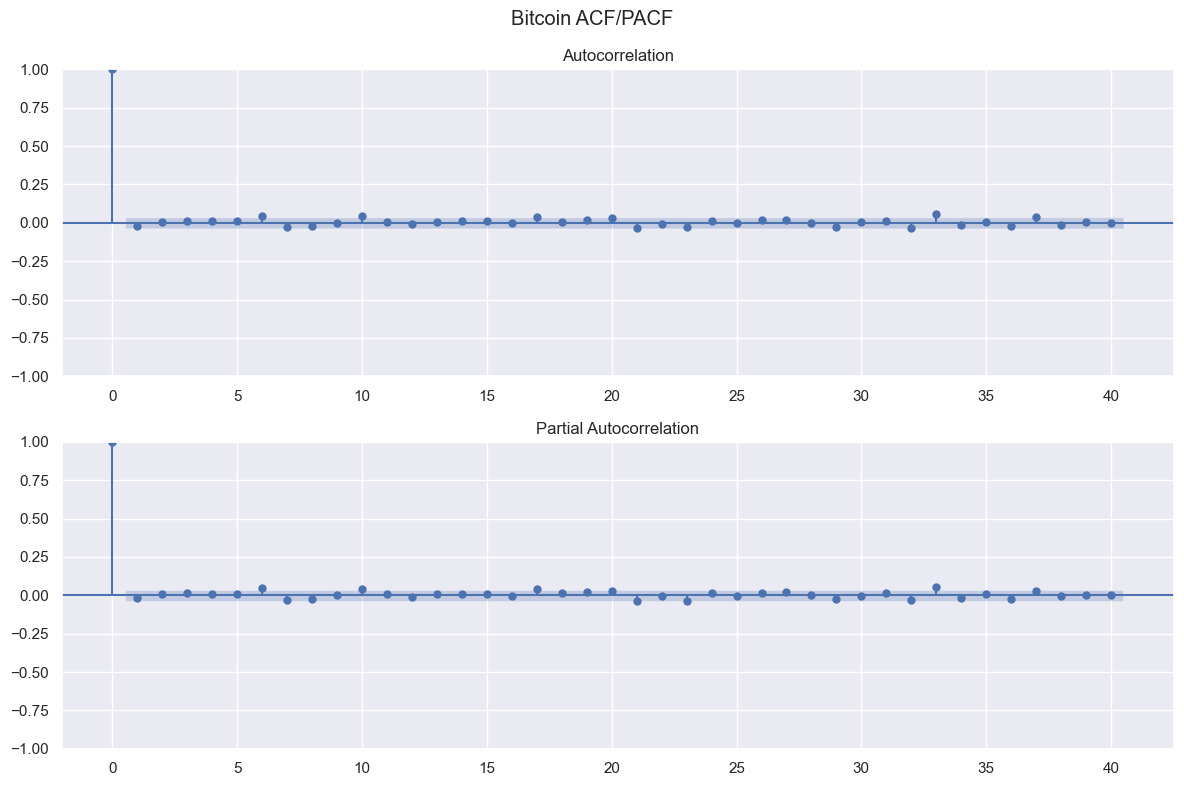

In [40]:
plot_autocorrelation(btc_returns, 'Bitcoin ACF/PACF')

## Non-linear Structure

### Volitality Clustering

In [52]:
def estimate_volitality(returns):
    model = arch.arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    result = model.fit(disp='off')
    return result.conditional_volatility

def plot_volatility(returns, vol, title):
    plt.figure(figsize=(12, 6))
    plt.plot(returns, alpha=0.5, label='Returns')
    plt.plot(vol, color='red', label='Conditional Volatility')
    plt.title(title)
    plt.legend()
    plt.show()

In [57]:
sp500_vol = estimate_volitality(sp500_returns)
btc_vol = estimate_volitality(btc_returns)

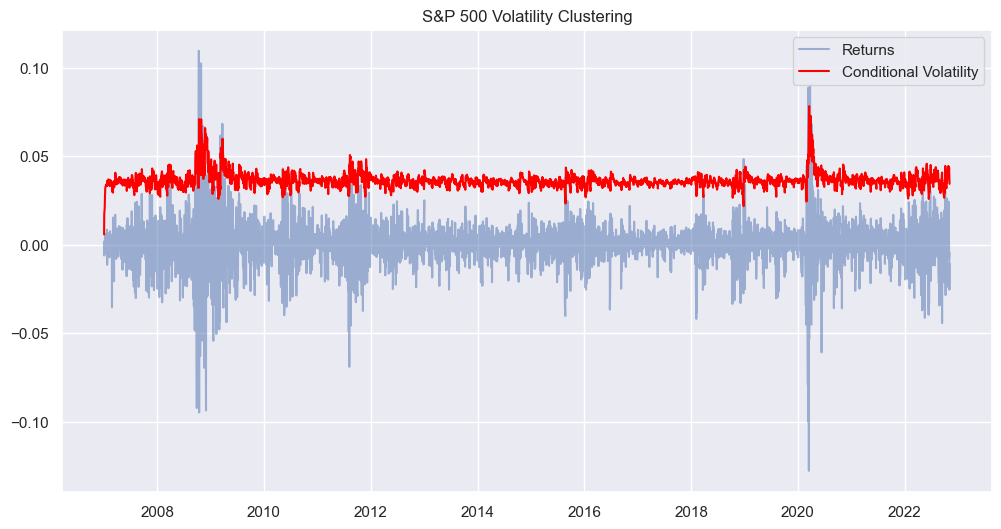

In [58]:
plot_volatility(sp500_returns, sp500_vol, 'S&P 500 Volatility Clustering')

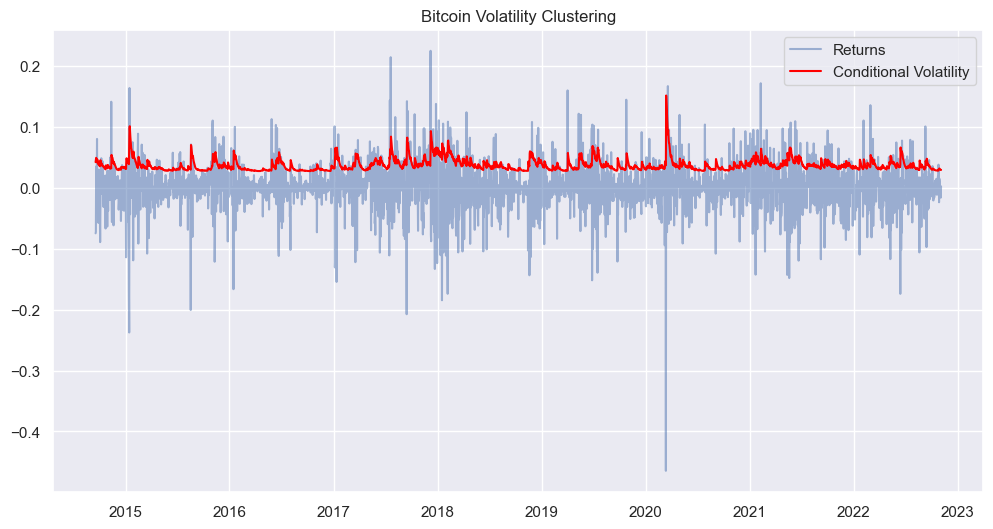

In [59]:
plot_volatility(btc_returns, btc_vol, 'Bitcoin Volatility Clustering')

### Autocorrelation of absolute value of log-returns

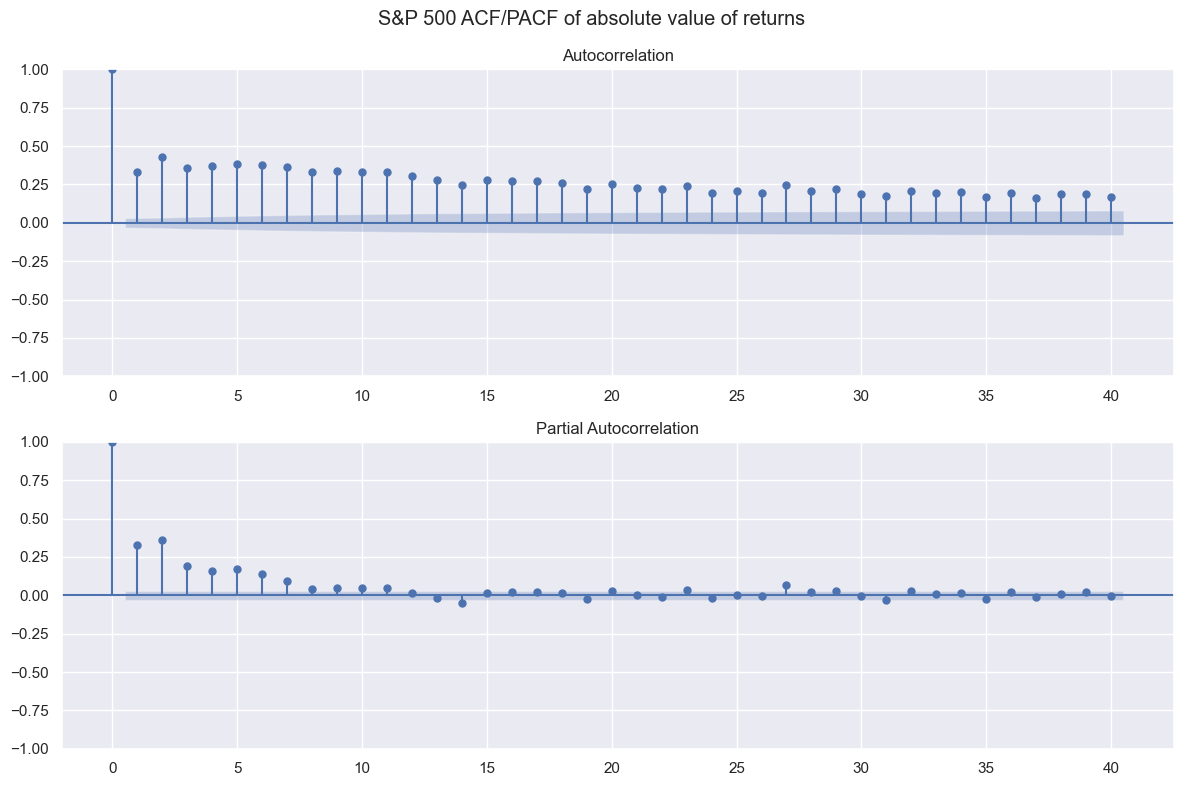

In [61]:
plot_autocorrelation(abs(sp500_returns), 'S&P 500 ACF/PACF of absolute value of returns')

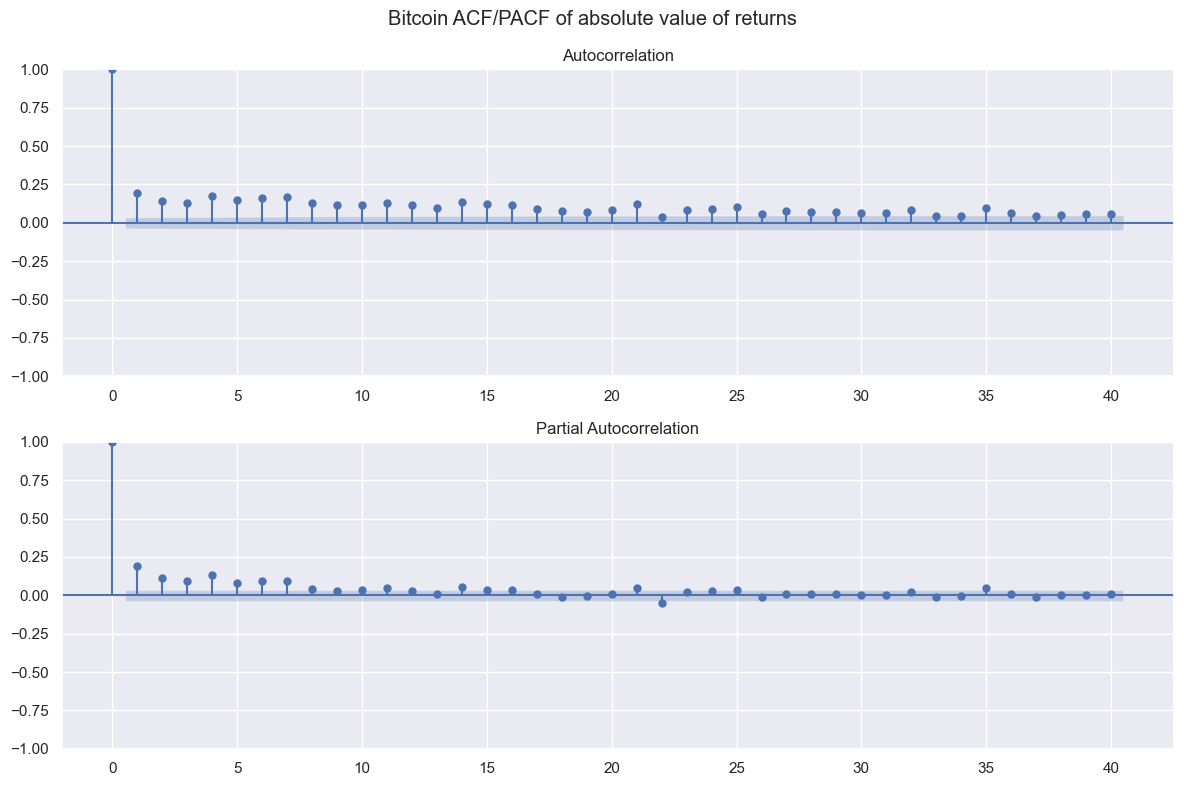

In [62]:
plot_autocorrelation(abs(btc_returns), 'Bitcoin ACF/PACF of absolute value of returns')

In [67]:
from pob_python import SP500_stocks_2015to2020, cryptos_2017to2021_hourly

def plot_correlation_matrix(prices, title):
    returns = np.log(prices).diff().dropna()
    corr_matrix = returns.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='viridis', xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.show()

In [71]:
data = SP500_stocks_2015to2020.sample(n=40, axis='columns')[-200:]
data.head()

,HSIC,PNR,RJF,LVS,TIF,AKAM,PXD,TXN,CNC,SPG,...,ROK,QRVO,HUM,WBA,ALL,CBOE,OXY,UAL,TPR,PPG
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-06,69.42,44.1377,89.1749,62.1938,130.9797,85.25,131.668,119.7261,60.98,143.115,...,195.267,106.62,346.314,56.8191,109.3050,119.2587,37.0383,88.58,25.1759,130.594
2019-12-09,68.68,44.3939,88.1113,62.2132,130.9110,84.11,130.970,119.3641,59.17,144.611,...,195.839,108.44,340.485,56.8967,109.5215,118.3390,36.1855,87.61,25.4421,131.027
2019-12-10,68.33,44.5023,88.1212,62.1938,130.8914,84.09,132.307,118.7477,59.62,143.887,...,196.814,109.86,342.753,56.6059,108.9508,114.3831,36.4084,86.51,25.1759,130.525
2019-12-11,69.10,44.8374,87.9734,63.4445,130.8620,83.85,133.920,121.0470,58.64,140.373,...,200.273,113.84,342.971,56.2183,107.8194,114.4227,36.3793,87.02,25.4618,130.367
2019-12-12,68.82,45.3005,89.6181,66.6051,130.9993,83.34,137.224,123.3462,58.52,139.031,...,202.450,115.35,345.210,56.7707,108.5671,114.1458,37.0674,88.47,25.9746,131.796


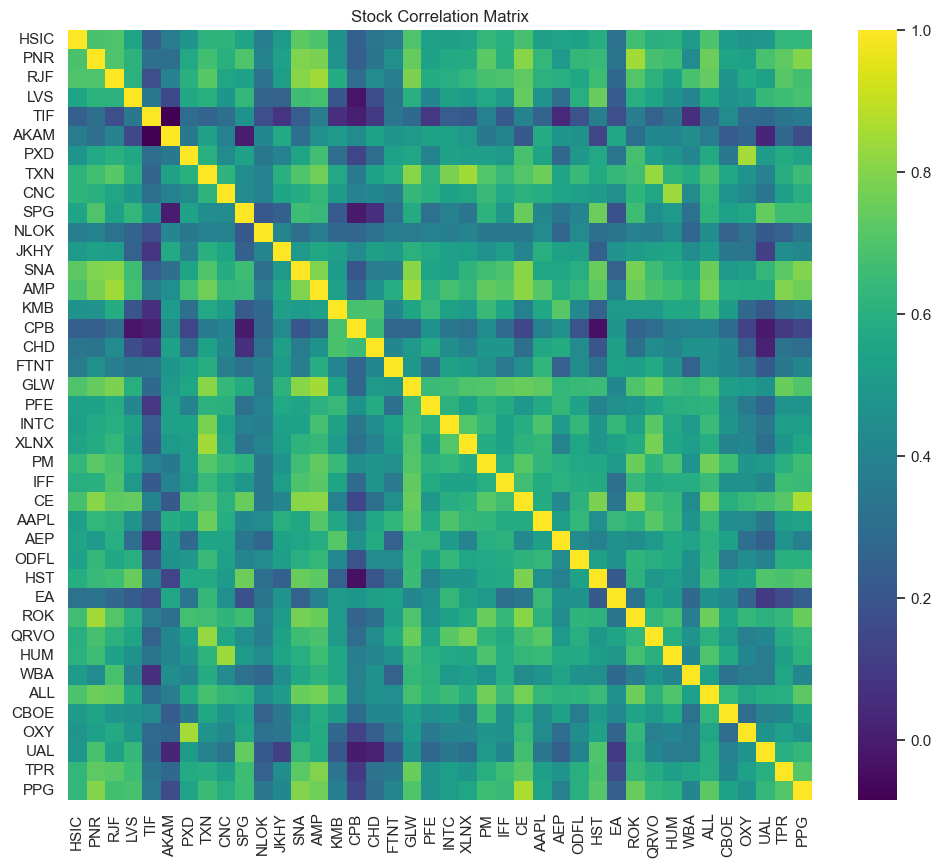

In [72]:
plot_correlation_matrix(data, 'Stock Correlation Matrix')

In [73]:
data = cryptos_2017to2021_hourly.sample(n=40, axis='columns')[-200:]
data.head()

,BAT,LSK,ZEC,ANKR,NEO,UNI,SOL,DASH,BTG,WBTC,...,BTT,XLM,AR,X1INCH,LRC,HOT,XEM,THETA,XTZ,CHZ
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-08 23:00:00,0.671254,3.064201,131.079726,0.090260,48.933761,23.418443,41.124720,166.127781,787.246073,33362.410450,...,0.003702,0.349479,17.069404,3.099249,0.319104,0.008448,0.164559,8.919563,3.446726,0.233320
2021-06-09 00:00:00,0.652800,2.979858,127.994803,0.088297,47.521195,22.863779,40.686364,162.755981,707.424513,32899.794656,...,0.003555,0.336430,16.022042,2.970650,0.325249,0.008084,0.161145,8.639978,3.305765,0.225931
2021-06-09 01:00:00,0.643312,2.911492,126.125629,0.086837,46.573466,22.509750,40.246044,160.828065,871.561269,32503.855978,...,0.003519,0.332714,15.589102,2.917672,0.314826,0.008189,0.159365,8.408592,3.266647,0.219208
2021-06-09 02:00:00,0.647824,2.987682,125.916503,0.088533,46.639394,22.533171,40.692296,160.789229,1009.041153,32877.650337,...,0.003583,0.332293,16.006285,2.923590,0.314873,0.008095,0.160395,8.602487,3.268044,0.220543
2021-06-09 03:00:00,0.646070,3.035807,126.617941,0.088261,46.861454,22.796816,40.509526,160.728873,1047.744566,32862.170000,...,0.003579,0.329608,16.073216,2.978298,0.314820,0.008179,0.159710,8.770585,3.287860,0.222477


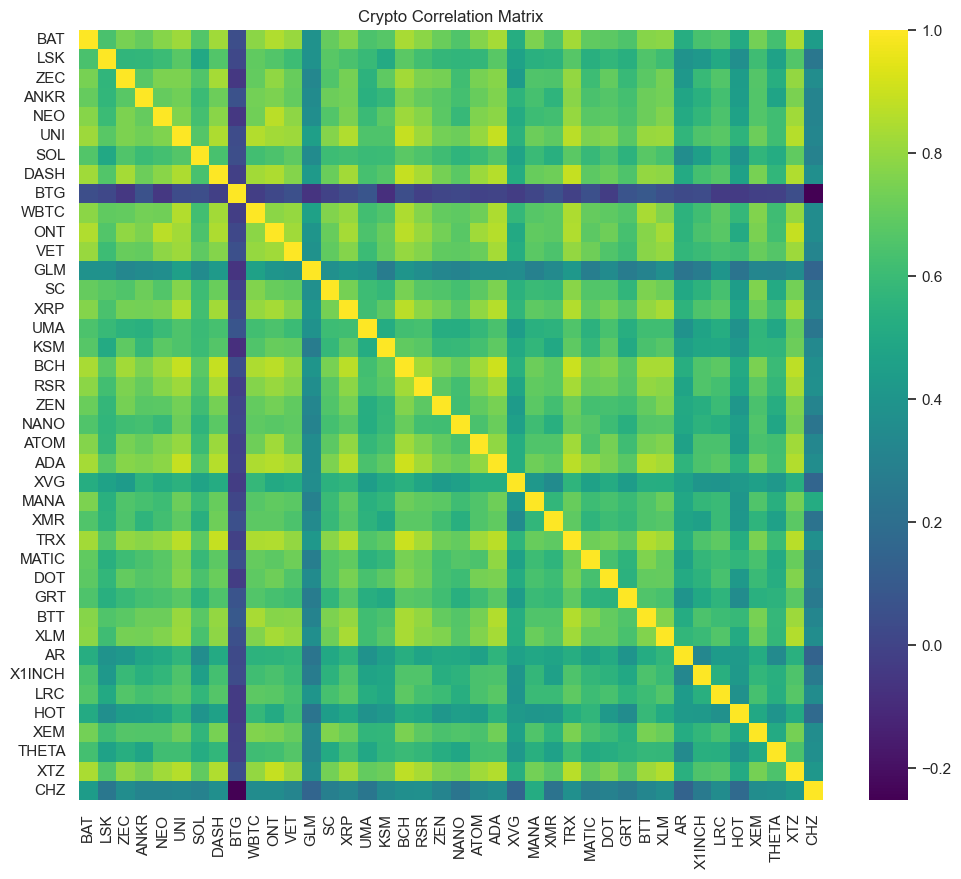

In [74]:
plot_correlation_matrix(data, 'Crypto Correlation Matrix')